In [3]:
import os
import tellurium as te
import numpy as np
import pygmo as pg
import matplotlib.pyplot as plt
import pandas as pd
import pickle

In [180]:
kegg_labels = pd.read_csv('kegg_labels.csv', index_col = 0)
translate_kegg = lambda X: [kegg_labels.loc[x].values[0] for x in X]

In [5]:
# load SBML model and get parameter labels
modelfile = os.getcwd()+'/models/240226MC_FULL.sbml' # filled nan values with mean for now
r_prefit = te.loadSBMLModel(modelfile)
model_rxns = pd.read_csv(os.getcwd()+'/src/frenda_brenda/Files/Reaction_181.csv')


In [6]:
# get data and metadata for experiment
with open('data/230623_Kinetics_DA/simulation_ready.pkl', 'rb') as f:
    simulation_ready = pickle.load(f)
    init_concentrations = simulation_ready['init_concentrations']   
    metadata = simulation_ready['metadata']
    measurements = simulation_ready['measurements']

In [9]:
# get all the parameters that can vary during the fitting
kinetics_labels = [p for p in r_prefit.getGlobalParameterIds() if np.any([k in p for k in ['Km','Kcat','Ki']])]
Gi_labels = [p for p in r_prefit.getGlobalParameterIds() if 'Gi' in p ]

sbml = r_prefit.getSBML()
metabolites = [s for s in r_prefit.getFloatingSpeciesIds() if 'EC' not in s]
metabolites_labels = [(sbml[sbml.find('<initialAssignment symbol="'+s+'">')+150:sbml.find('<initialAssignment symbol="'+s+'">')+156]).split(' ')[0] for s in metabolites]
translate_v = {v:m for v,m in zip(metabolites_labels, metabolites)}

parameter_labels = kinetics_labels + Gi_labels + metabolites_labels # + list(metabolites_labels)
parameter_labels.append('rel0') # what are good bounds for this?

# make upper and lower bounds
upper = np.array([r_prefit[i]*10 for i in kinetics_labels] + [1 for _ in Gi_labels] + [10 for _ in metabolites_labels] + [10])
lower = np.array([r_prefit[i]/10 for i in kinetics_labels] + [1/100 for _ in Gi_labels] + [1/10 for _ in metabolites_labels] + [1/10])
p_initial = np.array([r_prefit[i] for i in kinetics_labels] + [0.1 for _ in Gi_labels] + [1 for _ in metabolites_labels] + [1])

# define variables that don't change during fitting, but could be different across samples
# (dilution factor, biosynthesis metabolites, which enzymes are present)
variables = {}
for s in metadata['sample_labels']:
    variables[s] = {'dilution_factor':1/metadata['dilution_factor'][s]}
    variables[s] = {**variables[s] , **{p:1 for p in r_prefit.getGlobalParameterIds() if 'p_EC' in p}}
    variables[s] = {**variables[s] , **init_concentrations[s]}

from src.fitting.pygmo_problems import SBMLGlobalFit_Multi_Fly
myprob = SBMLGlobalFit_Multi_Fly(
    model = modelfile, 
    data = measurements, 
    parameter_labels=parameter_labels, 
    lower_bounds=lower, upper_bounds=upper, 
    metadata=metadata,
    variables=variables,
    scale=True)

import pickle
with open('checkpoint_t.dat', 'rb') as file:
    pops = pickle.load(file)
top_pop = pg.population(pg.problem(myprob), size = 0)
list(map(top_pop.push_back, pops[0].get_x()[np.argsort(pops[0].get_f()[:,0])[:10],:],pops[0].get_f()[np.argsort(pops[0].get_f()[:,0])[:10],:]));

In [14]:
myprob._setup_rr()

all_results = {s:[] for s in metadata['sample_labels']}
for k,c in enumerate(pops[0].get_x()[np.argsort(pops[0].get_f()[:,0])[:12],:]):
    res_dict = myprob._simulate(myprob._unscale(c))
    # all_results = {s:all_results[s] + res_dict[s][:,myprob.cols[s]][myprob.rows[s],:]/len(pops) for s in metadata['sample_labels']}
    [all_results[s].append(res_dict[s][:,myprob.cols[s]][myprob.rows[s],:]) for s in metadata['sample_labels']]


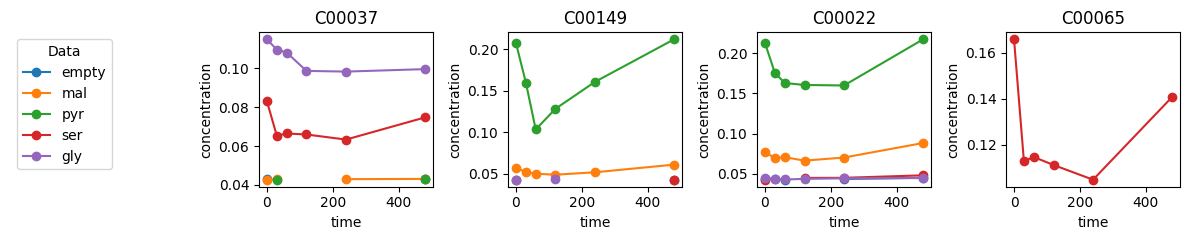

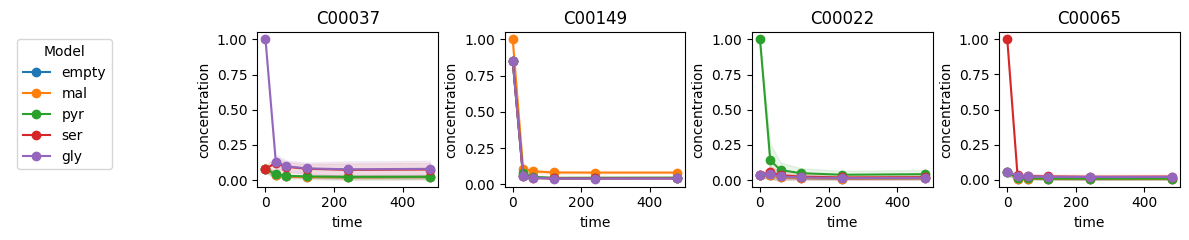

In [15]:
plt.figure(figsize=(12,2.5))
for s in metadata['sample_labels']:
    for i,m in enumerate(metadata['measurement_labels']):
        plt.subplot(1,5,i+2)
        plt.plot(metadata['timepoints'][s]/60, measurements[s][:,i],'-o')
        plt.title(m)
        plt.xlabel('time')
        plt.ylabel('concentration')

plt.subplot(1,5,1)
[plt.plot(metadata['timepoints'][s], measurements[s][:,i]/np.nan,'-o') for s in metadata['sample_labels']]
plt.legend(metadata['sample_labels'], loc='upper left', title='Data')
plt.gca().axis('off')
plt.tight_layout()
    
plt.figure(figsize=(12,2.5))
for s in metadata['sample_labels']:
    for i,m in enumerate(metadata['measurement_labels']):
        plt.subplot(1,5,i+2)
        mean = np.mean(all_results[s],0)[:,i]
        std = np.std(all_results[s],0)[:,i]
        p = plt.plot(metadata['timepoints'][s]/60, mean,'-o')
        plt.fill_between(metadata['timepoints'][s]/60, mean - std, mean + std, alpha=0.1, color = p[-1].get_color())
        plt.title(m)
        plt.xlabel('time')
        plt.ylabel('concentration')

plt.subplot(1,5,1)
[plt.plot(metadata['timepoints'][s], measurements[s][:,i]/np.nan,'-o') for s in metadata['sample_labels']]
plt.legend(metadata['sample_labels'], loc='upper left', title='Model')
plt.gca().axis('off')
plt.tight_layout()

In [10]:
all_rates = {s:[] for s in metadata['sample_labels']}
all_concentrations = {s:[] for s in metadata['sample_labels']}
c = pops[0].champion_x
for t in metadata['timepoints']['empty'][1:]:
    from roadrunner import Config, RoadRunner
    Config.setValue(Config.ROADRUNNER_DISABLE_PYTHON_DYNAMIC_PROPERTIES, False)
    Config.setValue(Config.LOADSBMLOPTIONS_RECOMPILE, False) 
    Config.setValue(Config.LLJIT_OPTIMIZATION_LEVEL, 4)

    x = myprob._unscale(c)
    r = myprob.r       
    # set new parameters
    for l, v in zip(myprob.parameter_labels,x):
        if 'v' not in l:
            r.setValue('init('+l+')',v)
        else:
            r.setValue('init('+l+')',v*1000)

    # set variables and simulate
    results = {sample:myprob.data[sample]*(-np.inf) for sample in myprob.metadata['sample_labels']}
    rb = r.saveStateS()
    for sample in myprob.metadata['sample_labels']:
        r2 = RoadRunner()
        r2.loadStateS(rb)
        # set any variable
        for label, value in myprob.variables[sample].items():
            if not np.isnan(value):
                if label not in myprob.species_labels:
                    r2.setValue('init('+label+')', value) # we might need new assignment rules for heterologous enzymes
                else:
                    # r2.removeInitialAssignment(label) theres some bug here? it seems to also mess up with over valuesS
                    r2.setValue('['+label+']', value)
        all_concentrations[sample].append(r2.simulate(0,t,myprob.cvode_timepoints)[-1,1:].__array__())
        all_rates[sample].append(r2.getReactionRates())


([], [])

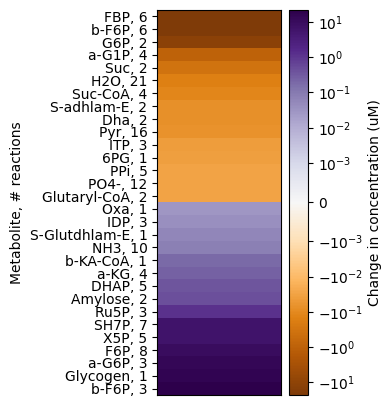

In [118]:
import matplotlib.colors as colors
most_change = np.argsort(all_concentrations['empty'][-1]-all_concentrations['empty'][0])[[*np.arange(15),*np.arange(-15,0)]]
plt.figure(figsize=(2,5))
plt.imshow((all_concentrations['empty'][-1][most_change]-all_concentrations['empty'][0][most_change])[np.newaxis].T,aspect='auto',cmap='PuOr',norm=colors.SymLogNorm(0.001))
plt.colorbar(label='Change in concentration (uM)')
plt.yticks(np.arange(len(most_change)),[translate_kegg([s])[0]+', '+str(len(np.where((myprob.r.getFullStoichiometryMatrix()[s]))[0])) for s in np.array(r.getFloatingSpeciesIds())[most_change]])
plt.ylabel('Metabolite, # reactions')
plt.xticks([])

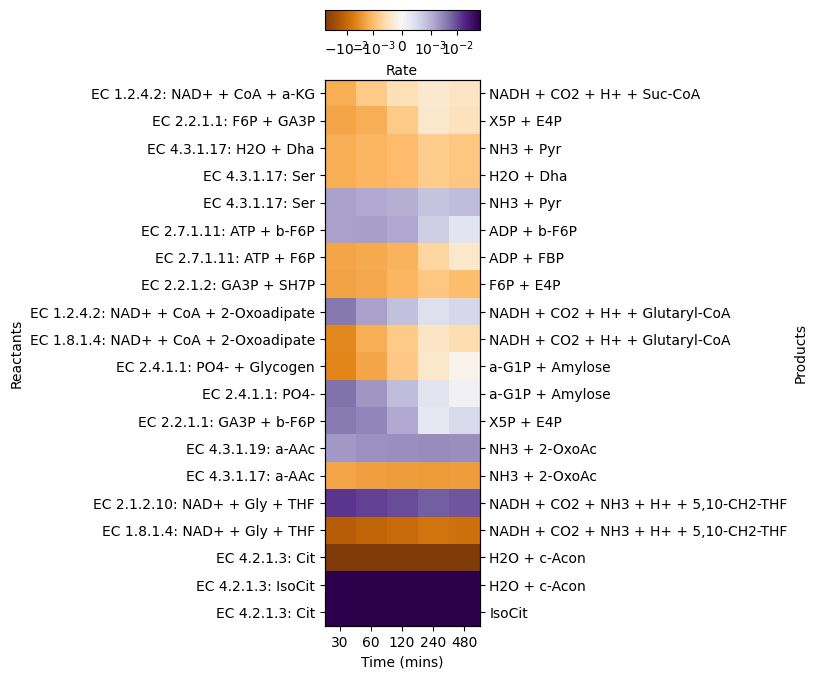

In [111]:
r_met = np.argsort(np.abs(rates).sum(axis=0))[-20:]

size = np.ceil(len(r_met)/3)+1
fig, ax = plt.subplots(figsize=(2, size))
fig.subplots_adjust(wspace=0.5)

im= ax.imshow(np.array(rates).T[r_met],aspect='auto',cmap='PuOr',norm=colors.SymLogNorm(0.001))
ax.set_ylabel('Reactants')
ax.set_xlabel('Time (mins)')
ax.set_xticks(np.arange(0,len(rates),1), labels = np.int16(metadata['timepoints']['empty'][1:]/60))

ax.set_yticks(np.arange(0,len(r_met),1), labels = ['EC '+model_rxns.loc[model_rxns['Label'] == r]['EC'].values[0] +': '+' + '.join((translate_kegg(model_rxns.loc[model_rxns['Label'] == r]['Substrates'].values[0].replace(" ",'').split(';')))) for r in np.array(r.getReactionIds())[r_met]])
ax2 = ax.twinx()
ax2.set_ylim(ax.get_ylim())
ax2.set_yticks(np.arange(0,len(r_met),1), labels = [' + '.join((translate_kegg(model_rxns.loc[model_rxns['Label'] == r]['Products'].values[0].replace(" ",'').split(';')))) for r in np.array(r.getReactionIds())[r_met]])
ax2.set_ylabel('Products')

divider = make_axes_locatable(ax2)
cax = divider.append_axes('top', size=0.2, pad=0.5)
cax.xaxis.set_ticks_position("both")
fig.colorbar(im, cax=cax, orientation='horizontal', label = 'Rate')

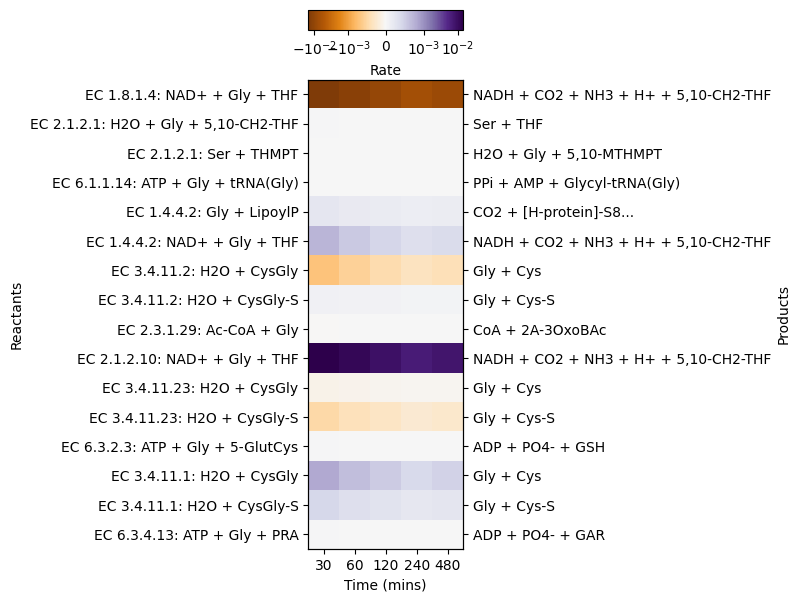

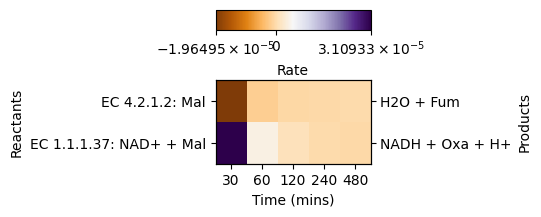

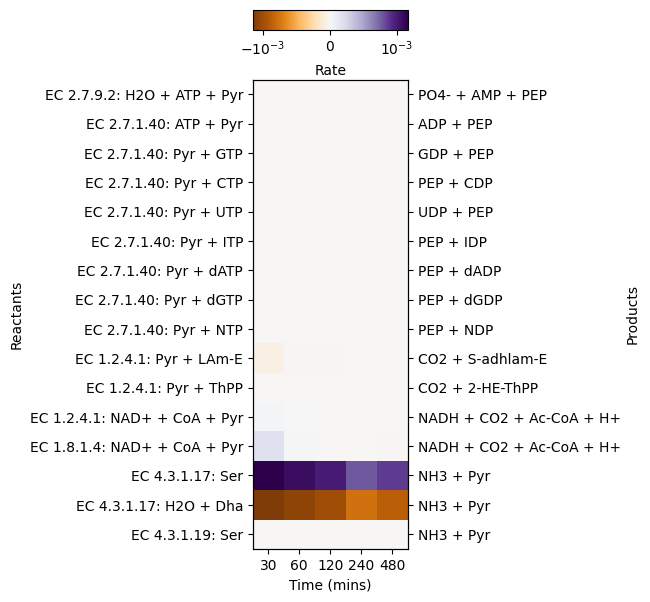

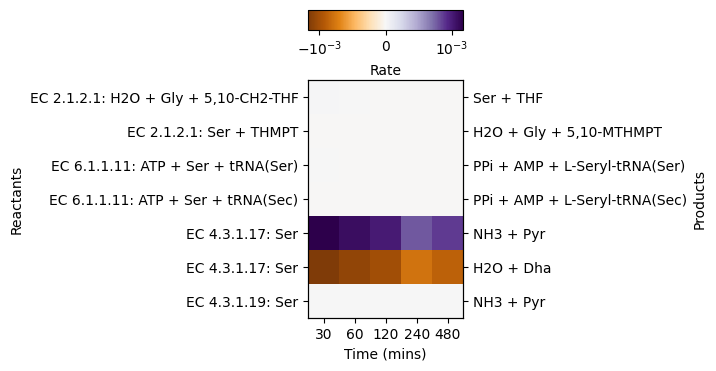

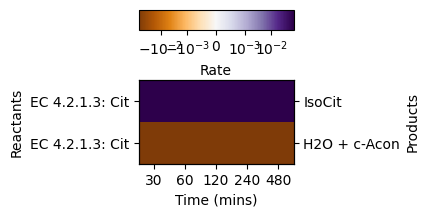

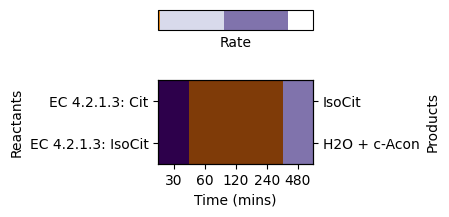

In [135]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as colors
kegg_labels = pd.read_csv('kegg_labels.csv', index_col = 0)
translate_kegg = lambda X: [kegg_labels.loc[x].values[0] for x in X]

rates = all_rates['empty']
# index of reactions involving metabolites
for s in ['C00037', 'C00149', 'C00022', 'C00065', 'C00158','C00311']:
    r_met = np.where(np.abs(myprob.r.getFullStoichiometryMatrix()[s]))[0]

    size = np.ceil(len(r_met)/3)+1
    fig, ax = plt.subplots(figsize=(2, size))
    fig.subplots_adjust(wspace=0.5)

    im= ax.imshow(np.array(rates).T[r_met],aspect='auto',cmap='PuOr',norm=colors.SymLogNorm(0.001))
    ax.set_ylabel('Reactants')
    ax.set_xlabel('Time (mins)')
    ax.set_xticks(np.arange(0,len(rates),1), labels = np.int16(metadata['timepoints']['empty'][1:]/60))

    ax.set_yticks(np.arange(0,len(r_met),1), labels = ['EC '+model_rxns.loc[model_rxns['Label'] == r]['EC'].values[0] +': '+' + '.join((translate_kegg(model_rxns.loc[model_rxns['Label'] == r]['Substrates'].values[0].replace(" ",'').split(';')))) for r in np.array(r.getReactionIds())[r_met]])
    ax2 = ax.twinx()
    ax2.set_ylim(ax.get_ylim())
    ax2.set_yticks(np.arange(0,len(r_met),1), labels = [' + '.join((translate_kegg(model_rxns.loc[model_rxns['Label'] == r]['Products'].values[0].replace(" ",'').split(';')))) for r in np.array(r.getReactionIds())[r_met]])
    ax2.set_ylabel('Products')

    divider = make_axes_locatable(ax2)
    cax = divider.append_axes('top', size=0.2, pad=0.5)
    cax.xaxis.set_ticks_position("both")
    fig.colorbar(im, cax=cax, orientation='horizontal', label = 'Rate')

#Required to remove some white border

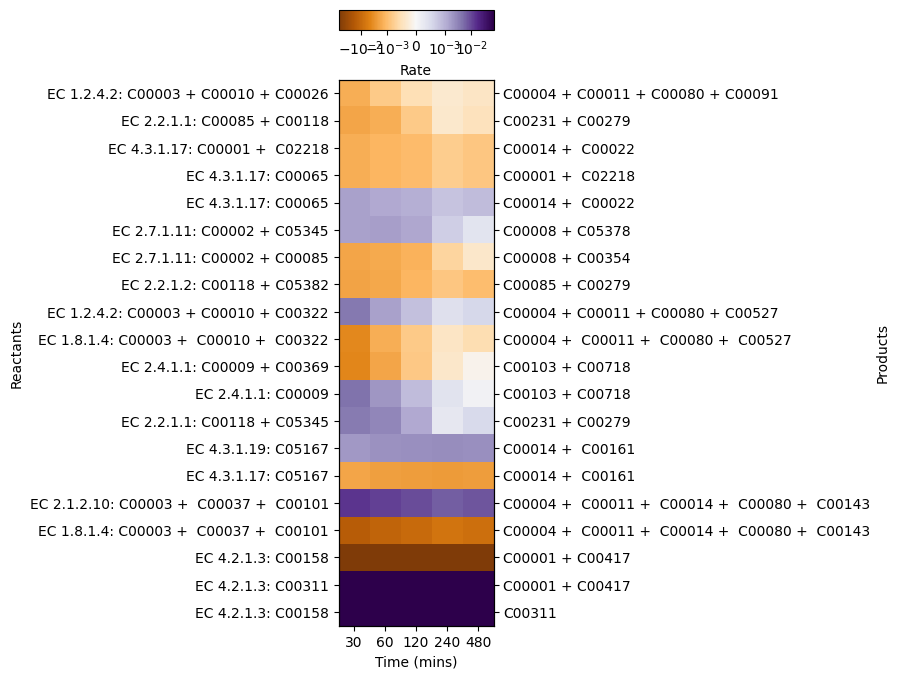

In [146]:
r_met = np.argsort(np.abs(rates).sum(axis=0))[-20:]

size = np.ceil(len(r_met)/3)+1
fig, ax = plt.subplots(figsize=(2, size))
fig.subplots_adjust(wspace=0.5)

im= ax.imshow(np.array(rates).T[r_met],aspect='auto',cmap='PuOr',norm=colors.SymLogNorm(0.001))
ax.set_ylabel('Reactants')
ax.set_xlabel('Time (mins)')
ax.set_xticks(np.arange(0,len(rates),1), labels = np.int16(metadata['timepoints']['empty'][1:]/60))

ax.set_yticks(np.arange(0,len(r_met),1), labels = ['EC '+model_rxns.loc[model_rxns['Label'] == r]['EC'].values[0] +': '+' + '.join((translate_kegg(model_rxns.loc[model_rxns['Label'] == r]['Substrates'].values[0].replace(" ",'').split(';')))) for r in np.array(r.getReactionIds())[r_met]])
ax2 = ax.twinx()
ax2.set_ylim(ax.get_ylim())
ax2.set_yticks(np.arange(0,len(r_met),1), labels = [model_rxns.loc[model_rxns['Label'] == r]['Products'].values[0].replace(';',' + ') for r in np.array(r.getReactionIds())[r_met]])
ax2.set_ylabel('Products')

divider = make_axes_locatable(ax2)
cax = divider.append_axes('top', size=0.2, pad=0.5)
cax.xaxis.set_ticks_position("both")
fig.colorbar(im, cax=cax, orientation='horizontal', label = 'Rate')

In [64]:
np.array(r.getReactionIds())[np.argsort(np.abs(rates).sum(axis=0))[-20:]]

array(['R58', 'R70', 'R171', 'R169', 'R168', 'R6', 'R5', 'R75', 'R55',
       'R149', 'R138', 'R137', 'R71', 'R174', 'R170', 'R162', 'R147',
       'R48', 'R49', 'R47'], dtype='<U4')

In [170]:
top_params = np.array(list(map(myprob._unscale, top_pop.get_x())))
mean_params = top_params.mean(0)
std_params = top_params.std(0)

In [148]:
r_prefit.getGlobalParameterIds()[1200]

'Gi_C00988_EC42111'

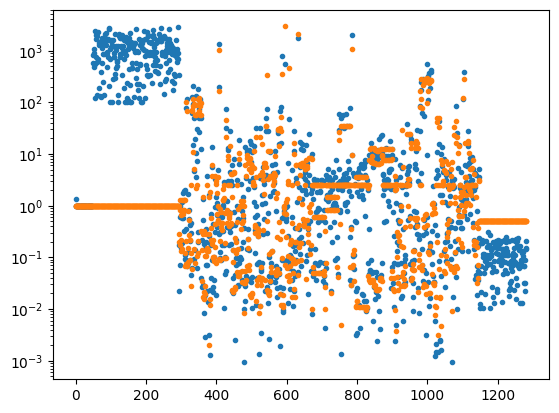

In [147]:
plt.plot(myprob.r.getGlobalParameterValues(),'.')
plt.plot(r_prefit.getGlobalParameterValues(),'.')
plt.yscale('log')

Text(0.5, 0, 'KcatF/R')

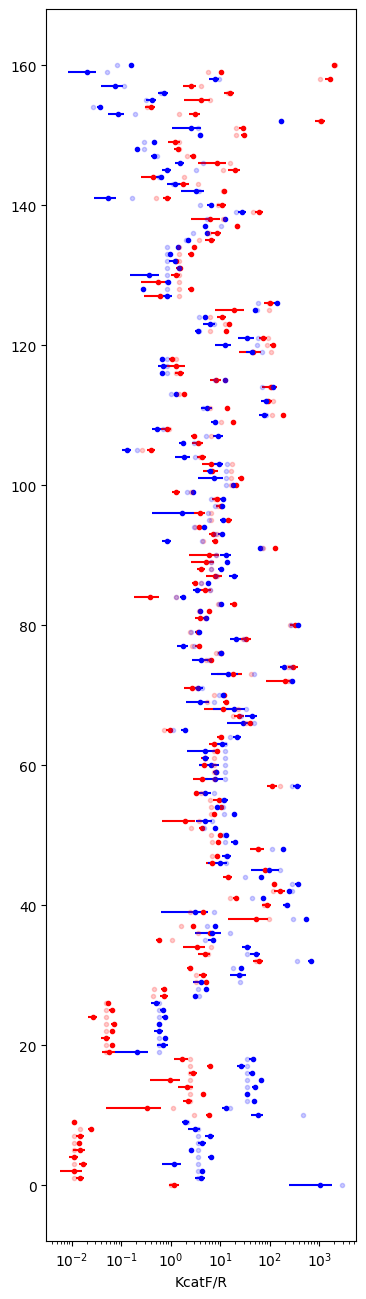

In [250]:
order = (np.argsort(p_initial[psF]/p_initial[psR]))
psF = [i for i,p in enumerate(parameter_labels) if 'Kcat_F' in p]
psR = [i for i,p in enumerate(parameter_labels) if 'Kcat_R' in p]
plt.figure(figsize=(4,16))
plt.errorbar(mean_params[psF][order],np.arange(len(psF)),xerr=std_params[psF][order]/2,fmt='r.')
plt.errorbar(mean_params[psR][order],np.arange(len(psR)),xerr=std_params[psR][order]/2,fmt='b.')
plt.errorbar(p_initial[psF][order],np.arange(len(psF)),fmt='r.', alpha = 0.2)
plt.errorbar(p_initial[psR][order],np.arange(len(psR)),fmt='b.', alpha = 0.2)
plt.xscale('log')
plt.xlabel('KcatF/R')

Text(0.5, 0, 'vCxxxx')

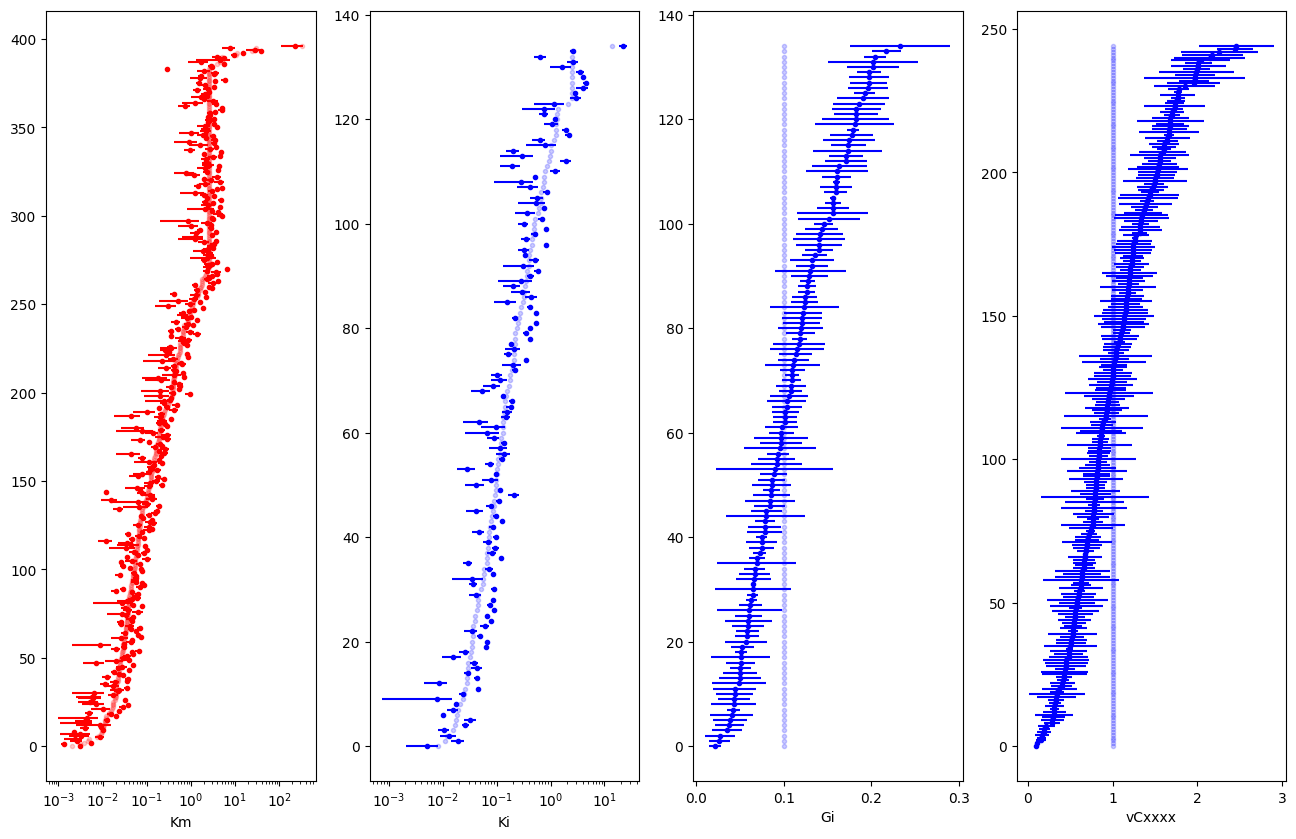

In [203]:
psKm = [i for i,p in enumerate(parameter_labels) if 'Km' in p]
order = np.argsort(p_initial[psKm])

plt.figure(figsize=(16,10))
plt.subplot(141)
plt.errorbar(mean_params[psKm][order],np.arange(len(psKm)),xerr=std_params[psKm][order]/2,fmt='r.')
plt.errorbar(p_initial[psKm][order],np.arange(len(psKm)),fmt='r.', alpha = 0.2)
plt.xscale('log')
plt.xlabel('Km')

psKi= [i for i,p in enumerate(parameter_labels) if 'Ki' in p]
order = np.argsort(p_initial[psKi])
plt.subplot(142)
plt.errorbar(mean_params[psKi][order],np.arange(len(psKi)),xerr=std_params[psKi][order]/2,fmt='b.')
plt.errorbar(p_initial[psKi][order],np.arange(len(psKi)),fmt='b.', alpha = 0.2)
plt.xscale('log')
plt.xlabel('Ki')

psGi= [i for i,p in enumerate(parameter_labels) if 'Gi' in p]
order = np.argsort(mean_params[psGi])
plt.subplot(143)
plt.errorbar(mean_params[psGi][order],np.arange(len(psGi)),xerr=std_params[psGi][order]/2,fmt='b.')
plt.errorbar(p_initial[psGi][order],np.arange(len(psGi)),fmt='b.', alpha = 0.2)
# plt.xscale('log')
plt.xlabel('Gi')

plt.subplot(144)
psKi= [i for i,p in enumerate(parameter_labels) if 'v' in p]
order = np.argsort(mean_params[psKi])
plt.errorbar(mean_params[psKi][order],np.arange(len(psKi)),xerr=std_params[psKi][order]/2,fmt='b.')
plt.errorbar(p_initial[psKi][order],np.arange(len(psKi)),fmt='b.', alpha = 0.2)
# plt.xscale('log')
plt.xlabel('vCxxxx')

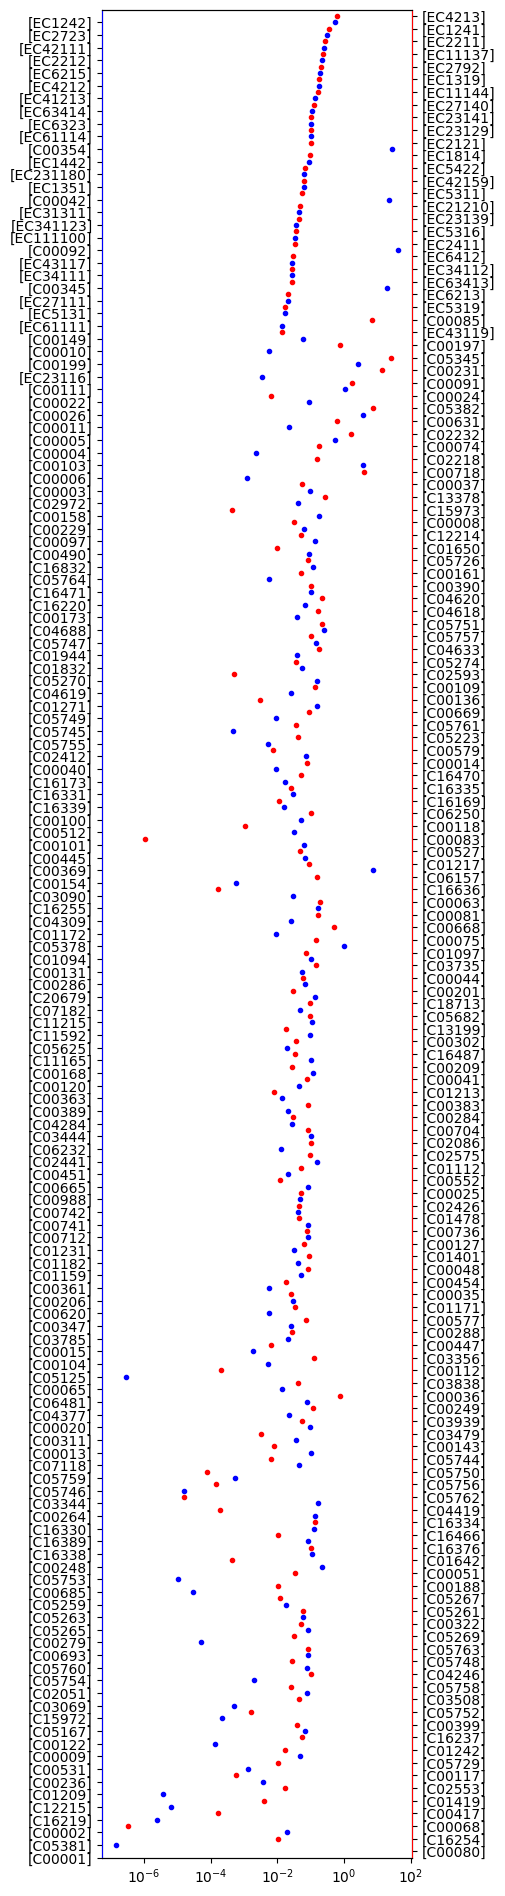

In [248]:
plt.figure(figsize=(4,24))
order = np.argsort([r_prefit[s] for s in r_prefit.getFloatingSpeciesConcentrationIds()])
plt.errorbar(all_concentrations['empty'][0][order][0::2],np.arange(len(order))[0::2], fmt='b.')
plt.xscale('log')
plt.yticks(np.arange(len(order))[0::2],np.array(r_prefit.getFloatingSpeciesConcentrationIds())[order][0::2]);
plt.ylim([0,len(order)])
ax2 = plt.gca().twinx()
ax2.set_yticks(np.arange(len(order))[1::2])
ax2.set_yticklabels(np.array(r_prefit.getFloatingSpeciesConcentrationIds())[order][1::2])
ax2.errorbar(all_concentrations['empty'][0][order][1::2],np.arange(len(order))[1::2], fmt='r.')
ax2.set_ylim([0,len(order)])
ax2.spines['right'].set_color('r')
ax2.spines['left'].set_color('b')

In [134]:
from sklearn.feature_selection import r_regression, mutual_info_regression
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor

pcorr = np.abs(r_regression(pops[0].get_x(), np.squeeze(pops[0].get_f())))
mi = mutual_info_regression(pops[0].get_x(), np.squeeze(pops[0].get_f()))
fi = AdaBoostRegressor(DecisionTreeRegressor(), n_estimators=100).fit(pops[0].get_x(), np.squeeze(pops[0].get_f())).feature_importances_

In [135]:
top_n = 300
pcorr_order = np.argsort(pcorr)[-top_n:]
mi_order = np.argsort(mi)[-top_n:]
fi_order = np.argsort(fi)[-top_n:]
top_idx = [i for i in np.arange(len(parameter_labels)) if (i in pcorr_order) and (i in mi_order) and (i in fi_order)]

pcorr_order = np.argsort(pcorr)[:top_n]
mi_order = np.argsort(mi)[:top_n]
fi_order = np.argsort(fi)[:top_n]
bot_idx = [i for i in np.arange(len(parameter_labels)) if (i in pcorr_order) and (i in mi_order) and (i in fi_order)]

In [219]:
dtype = [('var', 'S10'), ('C', 'S10'), ('EC', 'S10')]
np.array([tuple(p.split('_')) for p in parameter_labels],dtype=dtype)

ValueError: could not assign tuple of length 1 to structure with 3 fields.

In [207]:
np.sort([np.array(parameter_labels)[top_idx]])

array([['Gi_C00111_EC41213', 'Gi_C01213_EC63414', 'Gi_C11592_EC11137',
        'Kcat_F_R106', 'Kcat_F_R169', 'Kcat_F_R32', 'Kcat_F_R34',
        'Kcat_F_R65', 'Kcat_R_R137', 'Kcat_R_R65', 'Ki_C00010_EC11137',
        'Ki_C00020_EC31311', 'Ki_C00024_EC11137', 'Ki_C00036_EC11137',
        'Ki_C00199_EC11144', 'Ki_C05625_EC27140', 'Ki_C20679_EC31311',
        'Km_C00003_EC11137', 'Km_C00003_EC1814', 'Km_C00004_EC11137',
        'Km_C00004_EC1319', 'Km_C00004_EC1814', 'Km_C00011_EC1241',
        'Km_C00036_EC11137', 'Km_C00037_EC34112', 'Km_C00101_EC2121',
        'Km_C00149_EC11137', 'Km_C00158_EC4213', 'Km_C00369_EC2411',
        'Km_C01271_EC111100', 'Km_C05744_EC231180', 'Km_C05749_EC1319',
        'Km_C06157_EC1242', 'rel0', 'v129', 'v145', 'v149', 'v160',
        'v163', 'v6', 'v72', 'v98']], dtype='<U18')

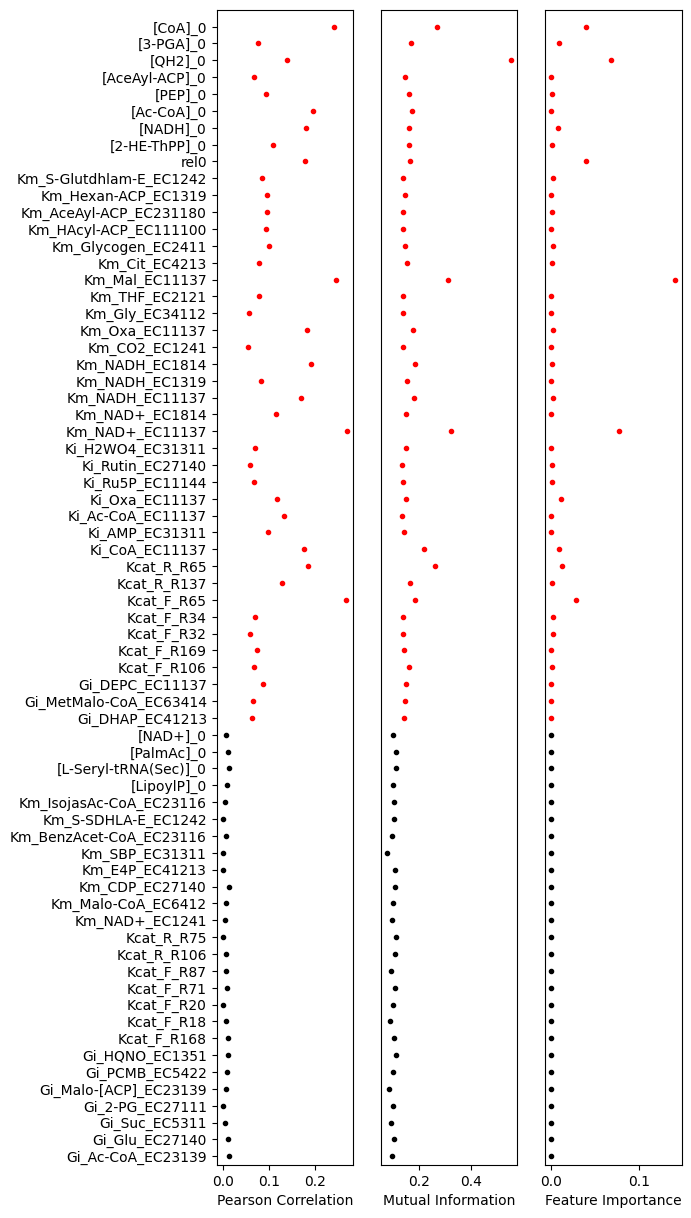

In [204]:
v_to_label = lambda x: '['+translate_kegg([translate_v[x]])[0]+"]_0"

plt.figure(figsize=(6,15))
labels = ['Pearson Correlation','Mutual Information','Feature Importance']
for i,var in enumerate([pcorr, mi, fi]):
    plt.subplot(1,3,i+1)
    order = np.array(top_idx)[np.argsort(np.array(parameter_labels)[top_idx])]
    plt.errorbar(var[order],np.arange(len(bot_idx),len(top_idx + bot_idx)), fmt='r.')

    order2 = np.array(bot_idx)[np.argsort(np.array(parameter_labels)[bot_idx])]
    plt.errorbar(var[order2],np.arange(0,len(bot_idx)), fmt='k.')

    if i == 0:
        ylabels = list(np.array(parameter_labels)[order2])+list(np.array(parameter_labels)[order])
        for k,l in enumerate(ylabels):
            if 'v' in l:
                ylabels[k] = v_to_label(l)

            elif '_C' in l:
                kg = l.split('_')[1]
                ylabels[k] = l.replace(kg,translate_kegg([kg])[0])

        plt.yticks(np.arange(len(top_idx + bot_idx)),ylabels);
    else:
        plt.yticks([])
    plt.ylim([-0.5,len(top_idx + bot_idx)])
    plt.xlabel(labels[i])

In [164]:
translate_v['v228']

'C02051_0'

[]

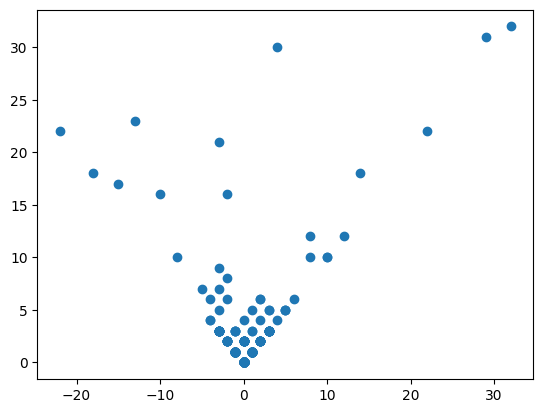

In [23]:
r.getFullStoichiometryMatrix()plt.plot(().sum(axis=1),np.abs(r.getFullStoichiometryMatrix()).sum(axis=1),'o')
plt.plot()

In [57]:
# index of species involved in reactions involving pyruvate
s_pyr = np.where(np.abs(r.getFullStoichiometryMatrix()[:,r_pyr]).sum(1))[0]

In [62]:
r.getFullStoichiometryMatrix()[s_pyr,:][:,r_pyr]

 [[ -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0],
  [ -1, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
  [  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1, -1,  0,  0,  0],
  [  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  0,  0,  0],
  [  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
  [  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
  [  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1, -1,  0,  0,  0],
  [  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  0,  0,  0],
  [  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1],
  [  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
  [  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
  [ -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  1,  1,  1],
  [  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  0,  0,  0],
  [  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
  [  0,  0, -1,  0,  0,  0,  0,  0

In [68]:
plt.plot(r.getFloatingSpeciesInitConcentrations()[s_pyr])

AttributeError: getFloatingSpeciesInitConcentrations

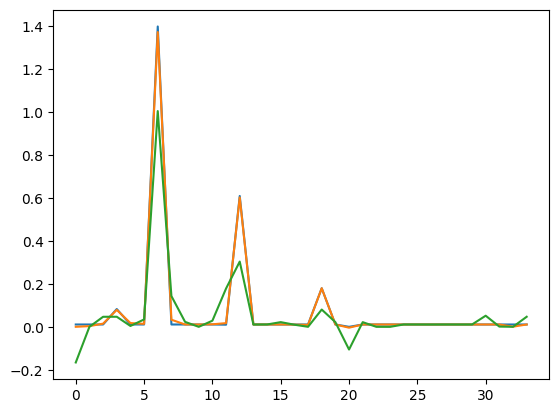

In [70]:
r.resetToOrigin()
plt.plot(r.getFloatingSpeciesConcentrations()[s_pyr])
r.simulate(0, 0.0001, 1000)
plt.plot(r.getFloatingSpeciesConcentrations()[s_pyr])
r.simulate(0, 1000, 1000)
plt.plot(r.getFloatingSpeciesConcentrations()[s_pyr])

array(['R26', 'R27', 'R28', 'R29', 'R30', 'R31', 'R32', 'R33', 'R34',
       'R43', 'R44', 'R45', 'R146', 'R168', 'R171', 'R173'], dtype='<U4')